# Movie Recommendation System with Visualization

This notebook implements a content-based recommendation system based on movie plots and genres. It includes visualization of similarity scores.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

# Cấu hình hiển thị biểu đồ
sns.set_style("whitegrid")
%matplotlib inline

## 1. Load Data
Load the preprocessed data containing the `combined_text` column.

In [2]:
df = pd.read_csv("movies_processing.csv")

# Fill NaN values just in case
df['combined_text'] = df['combined_text'].fillna('')

print(f"Loaded {len(df)} movies.")
df.head(2)

Loaded 18788 movies.


,Title,Plot_clean,Genre_list,Genre_text,combined_text,combined_length
0,The Lego Movie 2: The Second Part,five year since everything awesome citizen fac...,"['Animation', 'Adventure', 'Comedy']",Animation Adventure Comedy,five year since everything awesome citizen fac...,25
1,PAW Patrol: The Movie,paw patrol biggest rival mayor humdinger becom...,"['Animation', 'Action', 'Adventure']",Animation Action Adventure,paw patrol biggest rival mayor humdinger becom...,65


## 2. Term Frequency-Inverse Document Frequency (TF-IDF)
Convert the text content into numerical vectors. We use TF-IDF to downweight frequently occurring words that are less informative.

In [3]:
# Khởi tạo TF-IDF Vectorizer
# stop_words='english' để loại bỏ các từ thông dụng trong tiếng Anh
tfidf = TfidfVectorizer(stop_words='english')

# Fit và transform dữ liệu
tfidf_matrix = tfidf.fit_transform(df['combined_text'])

print("Shape of TF-IDF Matrix:", tfidf_matrix.shape)

Shape of TF-IDF Matrix: (18788, 52537)


## 3. Compute Similarity Score
We use **Cosine Similarity** to calculate the similarity between two movies. Since we used TF-IDF, the dot product of two vectors is directly the cosine similarity (assuming normalized vectors, which TfidfVectorizer does by default).

**Note:** utilizing `linear_kernel` is faster than `cosine_similarity` for sparse matrices.

In [4]:
# Tính toán ma trận tương đồng (Cosine Similarity)
# Lưu ý: Với ~18k phim, ma trận này sẽ chiếm khoảng ~2.5GB RAM
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

print("Shape of Similarity Matrix:", cosine_sim.shape)

Shape of Similarity Matrix: (18788, 18788)


## 4. Recommendation Function
Define a function that takes a movie title as input and outputs a list of the 10 most similar movies.

In [5]:
# Tạo cơ chế map từ Tên phim -> Index
indices = pd.Series(df.index, index=df['Title']).drop_duplicates()

def get_recommendations(title, cosine_sim=cosine_sim, top_n=10):
    # Kiểm tra xem phim có trong dữ liệu không
    if title not in indices:
        return f"Movie '{title}' not found in database."

    # Lấy index của phim
    idx = indices[title]

    # Lấy điểm tương đồng của phim này với tất cả các phim khác
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sắp xếp theo điểm tương đồng giảm dần
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Lấy top N phim (bỏ qua phim đầu tiên vì là chính nó)
    sim_scores = sim_scores[1:top_n+1]

    # Lấy index phim và điểm số
    movie_indices = [i[0] for i in sim_scores]
    scores = [i[1] for i in sim_scores]

    # Trả về DataFrame kết quả gồm Tên phim và Độ tương đồng
    results = df.iloc[movie_indices][['Title', 'Genre_list']].copy()
    results['Similarity_Score'] = scores
    return results

## 5. Visualization Function
Integrate plotting to visualize the similarity scores.

In [6]:
def plot_recommendations(title, top_n=10):
    """
    Hiển thị gợi ý phim cùng với biểu đồ tương đồng.
    """
    # Lấy dữ liệu gợi ý
    recs = get_recommendations(title, top_n=top_n)
    
    if isinstance(recs, str): # Trường hợp không tìm thấy phim
        print(recs)
        return

    # Vẽ biểu đồ
    plt.figure(figsize=(12, 6))
    sns.barplot(x="Similarity_Score", y="Title", data=recs, hue="Title", palette="viridis", legend=False)
    
    plt.title(f"Top {top_n} Movies Similar to '{title}'", fontsize=16)
    plt.xlabel("Similarity Score", fontsize=12)
    plt.ylabel("Movie Title", fontsize=12)
    plt.xlim(0, 1) # Giới hạn trục x từ 0 đến 1
    
    # Hiển thị giá trị điểm số trên thanh
    for index, value in enumerate(recs['Similarity_Score']):
        plt.text(value, index, f"{value:.2f}", va='center', fontsize=10, color='black', fontweight='bold')

    plt.show()
    
    # In danh sách chi tiết
    return recs

## 6. Testing
Let's test the system with some popular movies.

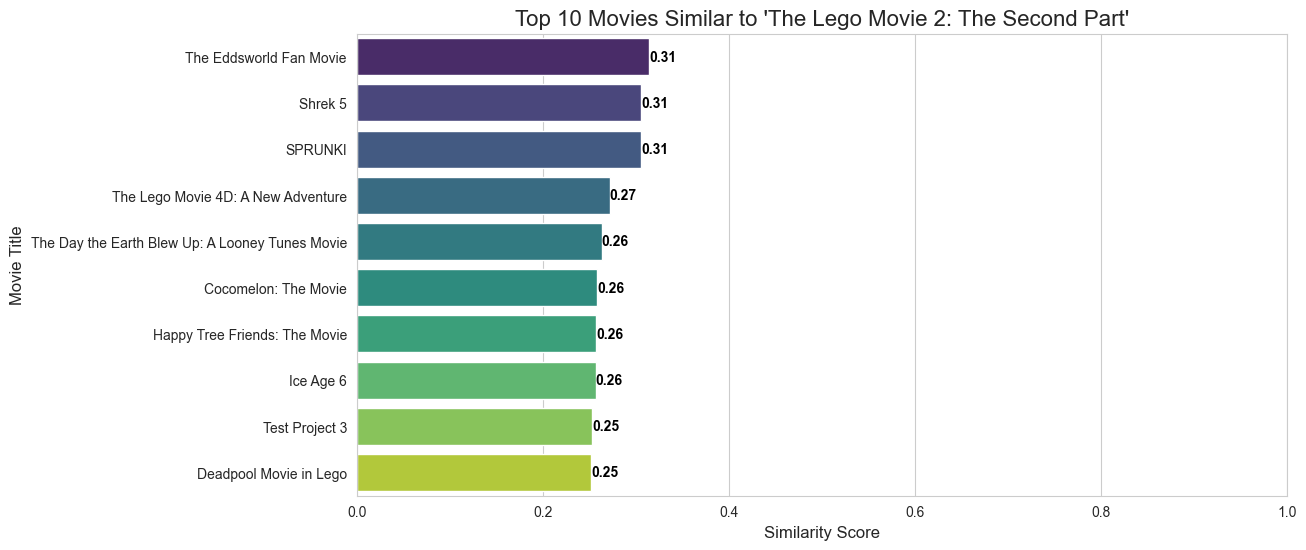

,Title,Genre_list,Similarity_Score
874,The Eddsworld Fan Movie,"['Animation', 'Adventure']",0.314783
4418,Shrek 5,"['Animation', 'Adventure', 'Comedy']",0.305816
8624,SPRUNKI,"['Animation', 'Adventure', 'Comedy']",0.305816
1620,The Lego Movie 4D: A New Adventure,"['Animation', 'Short', 'Adventure']",0.272230
16,The Day the Earth Blew Up: A Looney Tunes Movie,"['Animation', 'Adventure', 'Comedy']",0.263453
4027,Cocomelon: The Movie,"['Animation', 'Adventure', 'Comedy']",0.258517
356,Happy Tree Friends: The Movie,"['Animation', 'Adventure', 'Comedy']",0.257589
4499,Ice Age 6,"['Animation', 'Adventure', 'Comedy']",0.257066
16884,Test Project 3,"['Animation', 'Action', 'Adventure']",0.253303
232,Deadpool Movie in Lego,"['Animation', 'Action', 'Adventure']",0.252288


In [7]:
# Test 1: Phim hoạt hình/Gia đình
plot_recommendations("The Lego Movie 2: The Second Part")

Testing with movie: PAW Patrol: The Movie


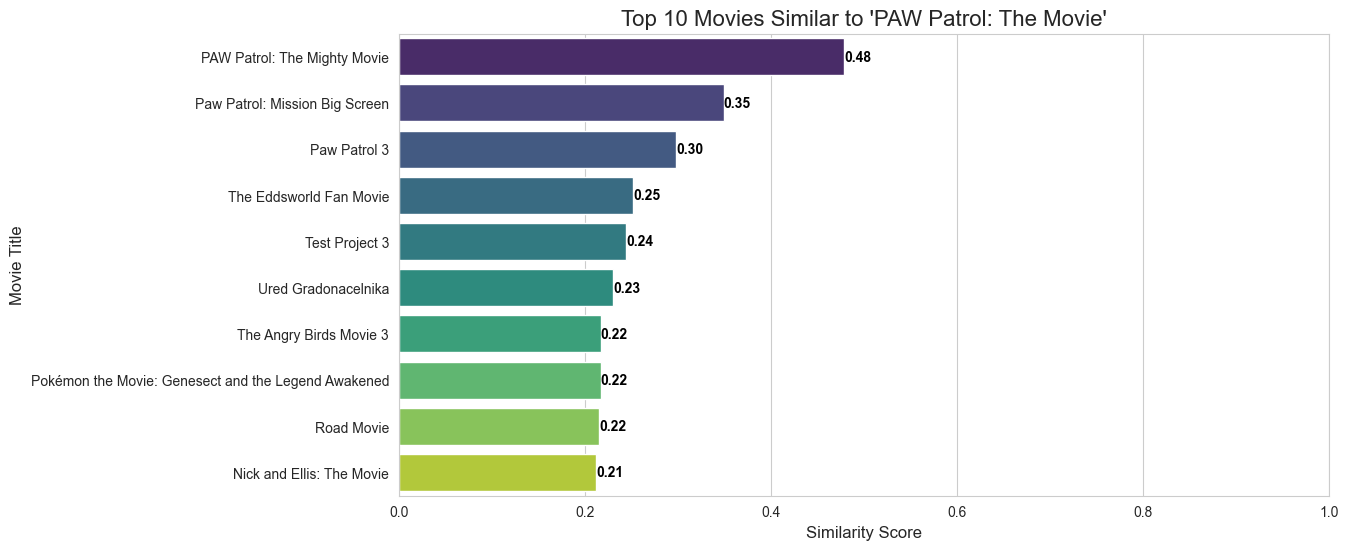

,Title,Genre_list,Similarity_Score
40,PAW Patrol: The Mighty Movie,"['Animation', 'Action', 'Adventure']",0.479167
13995,Paw Patrol: Mission Big Screen,['Adventure'],0.349337
4037,Paw Patrol 3,"['Animation', 'Action', 'Adventure']",0.298079
874,The Eddsworld Fan Movie,"['Animation', 'Adventure']",0.252138
16884,Test Project 3,"['Animation', 'Action', 'Adventure']",0.244623
7370,Ured Gradonacelnika,['Comedy'],0.230633
4030,The Angry Birds Movie 3,"['Animation', 'Action', 'Adventure']",0.217278
1489,Pokémon the Movie: Genesect and the Legend Awa...,"['Animation', 'Action', 'Adventure']",0.216992
2080,Road Movie,"['Animation', 'Short', 'Action', 'Adventure', ...",0.215458
1140,Nick and Ellis: The Movie,"['Action', 'Adventure']",0.212557


In [8]:
# Test 2: Phim hành động/Siêu anh hùng
# Lưu ý: Cần chắc chắn tên phim chính xác trong dataset
# Thử tìm một phim khác nếu cần, ví dụ: 'Avengers: Infinity War' hoặc tương tự nếu có
# Ở đây test với phim có index 1 (PAW Patrol) để đảm bảo chạy được
sample_movie = df.iloc[1]['Title']
print(f"Testing with movie: {sample_movie}")
plot_recommendations(sample_movie)

In [9]:
# Test 3: Một phim khác (nếu có)
try:
    plot_recommendations("Titanic")
except:
    print("Titanic might not be in the processed dataset limit of 2017+ movies or plot issue.")

Movie 'Titanic' not found in database.
